## Tratamento da base

In [ ]:
# Criar a base de dados que será utilizada para ajustar os modelos
import pandas as pd
df = pd.read_csv('koi_data.csv')
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,89.66,793.0,93.59,24.810,5.13585,28.47082,35.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.46229,48.14191,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,89.57,443.0,9.11,77.900,7.02767,20.10951,25.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.46226,48.14199,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,67.09,1395.0,891.96,3.278,39.06655,541.89510,505.6,5805.0,4.564,-0.52,0.791,0.836,15.597,16.100,15.554,15.382,15.266,14.326,13.911,13.809,0.000,19.03564,48.28521,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,85.41,1406.0,926.16,8.750,4.74994,33.19190,40.9,6031.0,4.438,0.07,1.046,1.095,15.509,16.015,15.468,15.292,15.241,14.366,14.064,13.952,0.733,19.25033,48.22626,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,60.92,1342.0,767.22,2.400,10.96468,46.15308,47.7,6227.0,3.986,0.00,1.958,1.358,12.660,12.999,12.609,12.515,12.480,11.659,11.415,11.396,0.000,19.92395,42.15826,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [ ]:
# Deletar a coluna "kepoi_name" e transformar a coluna "koi_disposition" em binário
df.drop(columns=['kepoi_name'], inplace=True)
df['koi_disposition'] = df['koi_disposition'].replace({'CONFIRMED': 1, 'FALSE POSITIVE': 0})
df.head()

,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,1,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,89.66,793.0,93.59,24.810,5.13585,28.47082,35.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.46229,48.14191,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,1,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,89.57,443.0,9.11,77.900,7.02767,20.10951,25.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.46226,48.14199,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,0,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,67.09,1395.0,891.96,3.278,39.06655,541.89510,505.6,5805.0,4.564,-0.52,0.791,0.836,15.597,16.100,15.554,15.382,15.266,14.326,13.911,13.809,0.000,19.03564,48.28521,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,1,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,85.41,1406.0,926.16,8.750,4.74994,33.19190,40.9,6031.0,4.438,0.07,1.046,1.095,15.509,16.015,15.468,15.292,15.241,14.366,14.064,13.952,0.733,19.25033,48.22626,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,0,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,60.92,1342.0,767.22,2.400,10.96468,46.15308,47.7,6227.0,3.986,0.00,1.958,1.358,12.660,12.999,12.609,12.515,12.480,11.659,11.415,11.396,0.000,19.92395,42.15826,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [ ]:
# Criar a matriz com as features e o vetor com a classe target
X = df.drop('koi_disposition', axis = 1)
y = df['koi_disposition']  

# Dividir a base em Treino e Teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=26)

É necessário controlar o estado de aleatoriedade para termos controle sobre o experimento.

In [ ]:
# Criar Scaler para normalizar os dados (criar no treino e aplicar no conjunto de teste)
from sklearn.preprocessing import MinMaxScaler
escala = MinMaxScaler()
X_train = escala.fit_transform(X_train)
X_test = escala.transform(X_test)

## Ajuste dos Modelos

**Baseline**

In [ ]:
# Baseline com o modelo Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_NaiveBayes = GaussianNB()
clf_NaiveBayes.fit(X_train, y_train)
y_pred = clf_NaiveBayes.predict(X_test)

# Avaliando o baseline
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)*100

91.4798206278027

O modelo utilizado como baseline, ou seja, sem nenhum ajuste de hipeparâmetros, conseguiu uma acurácia de **91%**. Esse será nosso referencial para avaliar a qualidade de ajuste dos demais modelos.

**Decision Tree**: Testar diferentes alturas de árvore.

In [ ]:
# Fazer validação cruzada com Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()
parametros = {'max_depth':[3, 5, 7, 9, 10]}
grid_tree = GridSearchCV(estimator=clf_tree, param_grid=parametros, scoring='accuracy', cv=5)

# Determinação dos melhores parâmetros
grid_tree.fit(X_train, y_train)
print(pd.DataFrame(grid_tree.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid_tree.best_params_}')

   rank_test_score  mean_test_score
1                1         0.954957
2                2         0.954134
3                3         0.951387
4                4         0.948641
0                5         0.934906
Melhores parâmetros: {'max_depth': 5}


Considerando diferentes tamanhos de árvore, ou regras de decisão, podemos avaliar que não existe um ganho muito significativo em desempenho entre diferentes tamanhos de árvore. Este comportamento pode estar relacionado ao fato de algumas features possibilitarem um alto ganho de informação, permitindo, assim, uma classificação satisfatória (acima do baseline) com árvores menores. A árvore que apresentou melhor desempenho é que a quem tem altura 5.

**SVM**: Avaliar os kernels linear, sigmoid, polinomial e RBF.

In [ ]:
# Fazer validação cruzada com SVM
from sklearn.svm import SVC

clf_svm = SVC()
parametros = {'kernel':['linear', 'sigmoid', 'poly', 'rbf']}
grid_svm = GridSearchCV(estimator=clf_svm, param_grid=parametros, scoring='accuracy', cv=5)

# Determinação dos melhores parâmetros
grid_svm.fit(X_train, y_train)
print(pd.DataFrame(grid_svm.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid_svm.best_params_}')

   rank_test_score  mean_test_score
2                1         0.916508
0                2         0.901951
3                3         0.889320
1                4         0.525684
Melhores parâmetros: {'kernel': 'poly'}


O melhor ajuste ocorreu com o kernel Polinomial, mas, ainda assim, não foi superior ao baseline. 

**k-NN**: Variar o número k de vizinhos.

In [ ]:
# Fazer validação cruzada com KNN
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
parametros = {'n_neighbors':[2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 20, 50]}
grid_knn = GridSearchCV(estimator=clf_knn, param_grid=parametros, scoring='accuracy', cv=5)

# Determinação dos melhores parâmetros
grid_knn.fit(X_train, y_train)
print(pd.DataFrame(grid_knn.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid_knn.best_params_}')

    rank_test_score  mean_test_score
3                 1         0.837683
5                 2         0.836860
8                 3         0.834387
7                 4         0.833564
10                5         0.829997
Melhores parâmetros: {'n_neighbors': 6}


O modelo que melhor ajustou os dados é aquele que utiliza 6 vizinhos. Mas, ainda assim, o KNN não é um bom modelo para este problema em particular, já que, mesmo com ajuste de parâmetros, apresentou desempenho abaixo do baseline.

**Random Forest**: Variar o número de árvores.

In [ ]:
# Fazer validação cruzada com Random Forest
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
parametros = {'n_estimators':[3, 5, 8, 12, 15, 20, 50, 100, 150]}
grid_rf = GridSearchCV(estimator=clf_rf, param_grid=parametros, scoring='accuracy', cv=5)

# Determinação dos melhores parâmetros
grid_rf.fit(X_train, y_train)
print(pd.DataFrame(grid_rf.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid_rf.best_params_}')

   rank_test_score  mean_test_score
8                1         0.967317
6                2         0.967041
4                3         0.966768
7                4         0.966494
5                5         0.964020
Melhores parâmetros: {'n_estimators': 150}


O modelo Random Forest apresentou desempenho acima do baseline. O melhor modelo foi o construído com 150 árvores. Esse resultado reforça o desempenho encontrado com Decision Tree, o que caracteriza esse tipo de modelo mais adequado para o problema em questão.

**Gradient Tree Boosting**: Variar o número de iterações.

In [ ]:
# Fazer validação cruzada com Gradient Tree Boosting
from sklearn.ensemble import GradientBoostingClassifier

clf_gtb = GradientBoostingClassifier()
parametros = {'n_iter_no_change':[3, 5, 8, 12, 15, 20, 50]}
grid_gtb = GridSearchCV(estimator=clf_gtb, param_grid=parametros, scoring='accuracy', cv=5)

# Determinação dos melhores parâmetros
grid_gtb.fit(X_train, y_train)
print(pd.DataFrame(grid_gtb.cv_results_)[['rank_test_score','mean_test_score']].sort_values('rank_test_score').head(5))
print(f'Melhores parâmetros: {grid_gtb.best_params_}')

   rank_test_score  mean_test_score
4                1         0.973358
6                2         0.971162
0                3         0.970611
2                4         0.970337
5                4         0.970337
Melhores parâmetros: {'n_iter_no_change': 15}


O modelo Gradient Tree Boosting apresentou o melhor desempenho no experimento em questão. Foi aplicado early stop em 15 iterações, o que garantiu uma acurácia de **97%**.

## Comparação entre os modelos

Agora que todos os modelos foram validados, será feita uma comparação das performances através de: **curva ROC**, **Precisão** e **Revocação** (precision e recall).


Precisão Naive Bayes: 0.8354253835425384
Revocação Naive Bayes: 0.9755700325732899



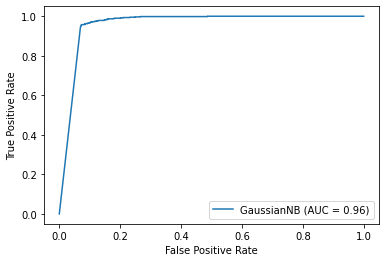

In [ ]:
# Avaliação final do modelo Naive Bayes
from sklearn import metrics 
y_nb = clf_NaiveBayes.predict(X_test)
print(f'Precisão Naive Bayes: {metrics.precision_score(y_test, y_nb)}\nRevocação Naive Bayes: {metrics.recall_score(y_test, y_nb)}\n')
metrics.plot_roc_curve(clf_NaiveBayes, X_test, y_test)

Precisão Decision Tree: 0.9015384615384615
Revocação Decision Tree: 0.9543973941368078



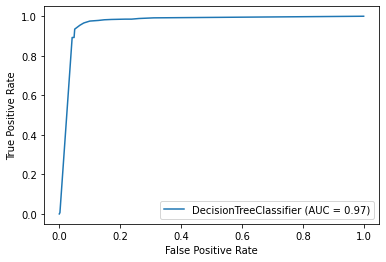

In [ ]:
# Avaliação final do modelo Decision Tree
final_tree = DecisionTreeClassifier(max_depth=5)
final_tree.fit(X_train, y_train)
y_dt = final_tree.predict(X_test)
print(f'Precisão Decision Tree: {metrics.precision_score(y_test, y_dt)}\nRevocação Decision Tree: {metrics.recall_score(y_test, y_dt)}\n')
metrics.plot_roc_curve(final_tree, X_test, y_test)

Precisão SVM: 0.8858447488584474
Revocação SVM: 0.9478827361563518



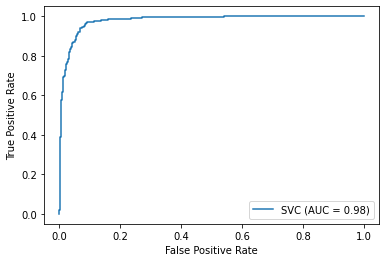

In [ ]:
# Avaliação final do modelo SVM
final_svm = SVC(kernel='poly')
final_svm.fit(X_train, y_train)
y_svm = final_svm.predict(X_test)
print(f'Precisão SVM: {metrics.precision_score(y_test, y_svm)}\nRevocação SVM: {metrics.recall_score(y_test, y_svm)}\n')
metrics.plot_roc_curve(final_svm, X_test, y_test)

Precisão KNN: 0.7782546494992847
Revocação KNN: 0.8859934853420195



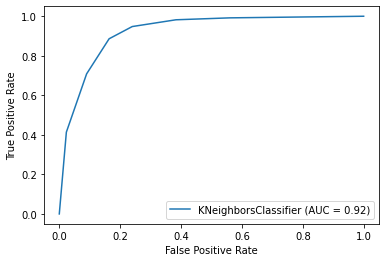

In [ ]:
# Avaliação final do modelo KNN
final_knn = KNeighborsClassifier(n_neighbors=6)
final_knn.fit(X_train, y_train)
y_knn = final_knn.predict(X_test)
print(f'Precisão KNN: {metrics.precision_score(y_test, y_knn)}\nRevocação KNN: {metrics.recall_score(y_test, y_knn)}\n')
metrics.plot_roc_curve(final_knn, X_test, y_test)

Precisão Random Forest: 0.955810147299509
Revocação Random Forest: 0.9511400651465798



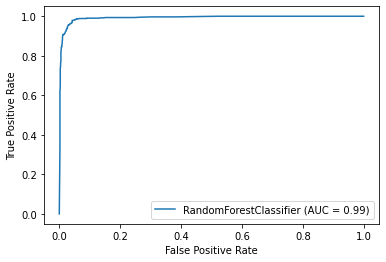

In [ ]:
# Avaliação final do modelo Random Forest
final_rf = RandomForestClassifier(n_estimators=150)
final_rf.fit(X_train, y_train)
y_rf = final_rf.predict(X_test)
print(f'Precisão Random Forest: {metrics.precision_score(y_test, y_rf)}\nRevocação Random Forest: {metrics.recall_score(y_test, y_rf)}\n')
metrics.plot_roc_curve(final_rf, X_test, y_test)

Precisão Gradient Tree Boosting: 0.9291338582677166
Revocação Gradient Tree Boosting: 0.9609120521172638



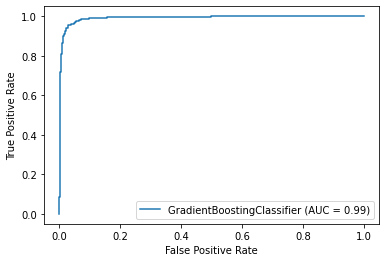

In [ ]:
# Avaliação final do modelo Gradient Tree Boosting
final_gtb = GradientBoostingClassifier(n_iter_no_change=15)
final_gtb.fit(X_train, y_train)
y_gtb = final_gtb.predict(X_test)
print(f'Precisão Gradient Tree Boosting: {metrics.precision_score(y_test, y_gtb)}\nRevocação Gradient Tree Boosting: {metrics.recall_score(y_test, y_gtb)}\n')
metrics.plot_roc_curve(final_gtb, X_test, y_test)